<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import tqdm
import torch
import matplotlib
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import model_selection

%load_ext autoreload
%autoreload 2

tf.__version__

'2.12.0'

##Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip \*.zip && rm *.zip

In [ ]:
IMAGE_PATH = '/content/data/images/'
ANNOTATION_PATH =  '/content/data/annotations/'

os.makedirs('/content/data/', exist_ok=True)
os.replace('/content/images', '/content/data/images')
os.replace('/content/annotations', '/content/data/annotations')

In [ ]:
def xml_to_XY(path, img_path):
  Y = []
  X = []
  for xml_file in glob.glob(path+'*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    img_name = img_path + xml_file.replace(path, '')[:-4]+'.png'

    h, w, d = plt.imread(img_name).shape

    img = tf.keras.preprocessing.image.load_img(img_name, target_size=(320, 320))
    img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    for children in root.findall('object'):
      bndbox = children[5]
      xmin = int(320 * float(bndbox[0].text) / w)
      ymin = int(320 * float(bndbox[1].text) / h)
      xmax = int(320 * float(bndbox[2].text) / w)
      ymax = int(320 * float(bndbox[3].text) / h)
      X.append(img_arr)
      Y.append([xmin, ymin, xmax, ymax])

  return X, Y

In [ ]:
x, y = xml_to_XY(ANNOTATION_PATH, IMAGE_PATH)

In [ ]:
x = np.array(x)
y = np.array(y)
x.shape, y.shape

((471, 320, 320, 3), (471, 4))

In [ ]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size=0.2, random_state=26)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((376, 320, 320, 3), (95, 320, 320, 3), (376, 4), (95, 4))

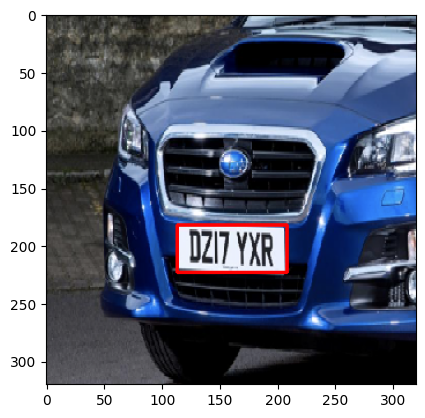

In [ ]:
N = np.random.randint(0, len(train_x))
img = train_x[N]
y = train_y[N]
image = cv2.rectangle(img, (y[0], y[1]), (y[2], y[3]), color=(255, 0, 0), thickness=2)
plt.imshow(image) 
plt.show()

#Part 1

##Model

In [ ]:
num_classes = 1
base_model = tf.keras.applications.VGG16(input_shape=[320, 320, 3], include_top=False)
base_model.trainable = False

# Define the RPN
rpn_conv = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', name='rpn_conv')
rpn_cls  = tf.keras.layers.Conv2D(9 * 2, 1, name='rpn_cls')
rpn_reg  = tf.keras.layers.Conv2D(9 * 4, 1, name='rpn_reg')

# Define the RoI pooling layer
roi_pooling = tf.keras.layers.Lambda(lambda x: tf.image.crop_and_resize(*x), name='roi_pooling')

# Define the classifier
classifier = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes + 1)
])
regressor = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes * 4)
])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Define the complete Faster R-CNN model
inputs = tf.keras.Input(shape=[None, None, 3])
x = base_model(inputs)
x_rpn_conv = rpn_conv(x)
x_rpn_cls = rpn_cls(x_rpn_conv)
x_rpn_reg = rpn_reg(x_rpn_conv)

rpn = tf.keras.Model(inputs, [x_rpn_cls, x_rpn_reg])

In [ ]:
x_rpn_cls, x_rpn_reg
x_rpn_conv
x

<KerasTensor: shape=(None, 10, 10, 512) dtype=float32 (created by layer 'vgg16')>

In [ ]:
def generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=[8, 16, 32]):
    # Compute the base anchor
    base_anchor = tf.constant([1, 1, base_size, base_size], dtype=tf.float32) - 1

    # Compute the ratio anchors
    ratio_anchors = _ratio_enum(base_anchor, ratios)

    # Compute the scale anchors
    anchors = tf.concat([_scale_enum(ratio_anchors[i, :], scales) for i in range(ratio_anchors.shape[0])], axis=0)
    return anchors

def _xy_to_whCenter(anchor):
    #Xmin, Xmax, Ymin, Ymax ==> width, height, Xcenter, Ycenter
    x1, y1, x2, y2 = anchor
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    x_ctr = x1 + (w-1)/2
    y_ctr = y1 + (h-1)/2
    return w, h, x_ctr, y_ctr


def _mkanchors(ws , hs , x_ctr , y_ctr):
# Given a vector of widths (ws) and heights (hs) around a center (x_ctr,y_ctr), output a set of anchors (windows).
  ws=tf.reshape(ws , [-1 , 1])
  hs=tf.reshape(hs , [-1 , 1])

  anchors=tf.concat([x_ctr - 0.5 * (ws-1), y_ctr - 0.5 * (hs-1), x_ctr + 0.5 * (ws-1), y_ctr + 0.5 * (hs-1)],axis=-1)
  return anchors

def _ratio_enum(anchor, ratios):
# Enumerate a set of anchors for each aspect ratio wrt an anchor.
  w, h, x_ctr, y_ctr = _xy_to_whCenter(anchor)
  size = w * h
  size_ratios = size / ratios
  ws = tf.round(tf.sqrt(size_ratios))
  hs = ws * ratios
  anchors=_mkanchors(ws , hs , x_ctr , y_ctr)
  return anchors

def _scale_enum(anchor,scales):
# Enumerate a set of anchors for each scale wrt an anchor.
  w, h, x_ctr, y_ctr=_xy_to_whCenter(anchor)
  ws=w*scales 
  hs=h*scales 
  anchors=_mkanchors(ws , hs , x_ctr , y_ctr)
  return anchors

In [ ]:
anchors = generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=[8, 16, 32])
anchors

<tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[ -84.,  -38.,   99.,   53.],
       [-176.,  -84.,  191.,   99.],
       [-360., -176.,  375.,  191.],
       [ -56.,  -56.,   71.,   71.],
       [-120., -120.,  135.,  135.],
       [-248., -248.,  263.,  263.],
       [ -36.,  -80.,   51.,   95.],
       [ -80., -168.,   95.,  183.],
       [-168., -344.,  183.,  359.]], dtype=float32)>

In [ ]:
def rpn_to_roi(rpn_cls, rpn_reg, anchors):
    # Convert logits to probabilities
    rpn_cls_prob = tf.nn.softmax(rpn_cls)

    # Get the foreground probabilities for each anchor
    fg_prob = rpn_cls_prob[..., 1]

    # Decode the predicted bounding boxes
    pred_boxes = decode_boxes(rpn_reg, anchors)

    # Apply non-maximum suppression to remove overlapping boxes
    indices = tf.image.non_max_suppression(pred_boxes, fg_prob,
                                           max_output_size=2000,
                                           iou_threshold=0.7)

    rois = tf.gather(pred_boxes, indices)
    
    return rois
    

def decode_boxes(deltas, anchors):
    # Compute the width and height of each anchor box
    wa = anchors[..., 2] - anchors[..., 0]
    ha = anchors[..., 3] - anchors[..., 1]

    # Compute the center coordinates of each anchor box
    xa = (anchors[..., 2] + anchors[..., 0]) / 2
    ya = (anchors[..., 3] + anchors[..., 1]) / 2

    # Decode the predicted bounding box deltas
    ty = deltas[..., 0]
    tx = deltas[..., 1]
    th = deltas[..., 2]
    tw = deltas[..., 3]
    print(deltas[..., 3].shape)
    w = tf.math.multiply(tf.math.exp(tw), wa)
    h = tf.math.multiply(tf.math.exp(th), ha)

    y = ty * ha + ya
    x = tx * wa + xa

    # Compute the coordinates of the decoded bounding boxes
    y1=x-w/2 
    x1=y-h/2 
    y2=x+w/2 
    x2=y+h/2 

    return tf.stack([y1,x1,y2,x2],axis=-1)

In [ ]:
rois = rpn_to_roi(x_rpn_cls, x_rpn_reg, anchors) # Generate RoIs using the RPN outputs

pooled_rois = roi_pooling([x] + rois)

cls_output = classifier(pooled_rois)
reg_output = regressor(pooled_rois)

faster_rcnn = tf.kers.Model(inputs, [cls_output, reg_output])

In [ ]:
rpn_reg[..., 0]

In [ ]:
rpn_reg[..., 0]

##Test

In [ ]:
import torch as tt
import numpy as np
from utils import array_tool as at
from model.utils.bbox_tools import loc2bbox
from torchvision.ops import nms

from torch import nn
from data.dataset import preprocess
from torch.nn import functional as F
from utils.config import opt


def nograd(f):
    def new_f(*args,**kwargs):
        with t.no_grad():
           return f(*args,**kwargs)
    return new_f

class FasterRCNN(nn.Module):HW image
    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)):
      
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset('evaluate')

    @property
    def n_class(self):
        # Total number of classes including the background.
        return self.head.n_class

    def forward(self, x, scale=1.):
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(
            h, rois, roi_indices)
        return roi_cls_locs, roi_scores, rois, roi_indices

    def use_preset(self, preset):
        if preset == 'visualize':
            self.nms_thresh = 0.3
            self.score_thresh = 0.7
        elif preset == 'evaluate':
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        else:
            raise ValueError('preset must be visualize or evaluate')

    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            keep = nms(cls_bbox_l, prob_l,self.nms_thresh)
            # import ipdb;ipdb.set_trace()
            # keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep].cpu().numpy())
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep].cpu().numpy())
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    @nograd
    def predict(self, imgs,sizes=None,visualize=False):
        self.eval()
        if visualize:
            self.use_preset('visualize')
            prepared_imgs = list()
            sizes = list()
            for img in imgs:
                size = img.shape[1:]
                img = preprocess(at.tonumpy(img))
                prepared_imgs.append(img)
                sizes.append(size)
        else:
             prepared_imgs = imgs 
        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = at.totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois, _ = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = at.totensor(rois) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = t.Tensor(self.loc_normalize_mean).cuda(). \
                repeat(self.n_class)[None]
            std = t.Tensor(self.loc_normalize_std).cuda(). \
                repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)),
                                at.tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = at.totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

            prob = (F.softmax(at.totensor(roi_score), dim=1))

            bbox, label, score = self._suppress(cls_bbox, prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset('evaluate')
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):
        lr = opt.lr
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': opt.weight_decay}]
        if opt.use_adam:
            self.optimizer = t.optim.Adam(params)
        else:
            self.optimizer = t.optim.SGD(params, momentum=0.9)
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from layers import *
from data import voc, coco
import os


class SSD(nn.Module):

    def __init__(self, phase, size, base, extras, head, num_classes):
        super(SSD, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        self.cfg = (coco, voc)[num_classes == 21]
        self.priorbox = PriorBox(self.cfg)
        self.priors = Variable(self.priorbox.forward(), volatile=True)
        self.size = size

        # SSD network
        self.vgg = nn.ModuleList(base)
        # Layer learns to scale the l2 normalized features from conv4_3
        self.L2Norm = L2Norm(512, 20)
        self.extras = nn.ModuleList(extras)

        self.loc = nn.ModuleList(head[0])
        self.conf = nn.ModuleList(head[1])

        if phase == 'test':
            self.softmax = nn.Softmax(dim=-1)
            self.detect = Detect(num_classes, 0, 200, 0.01, 0.45)

    def forward(self, x):
        sources = list()
        loc = list()
        conf = list()

        # apply vgg up to conv4_3 relu
        for k in range(23):
            x = self.vgg[k](x)

        s = self.L2Norm(x)
        sources.append(s)

        # apply vgg up to fc7
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)
        sources.append(x)

        # apply extra layers and cache source layer outputs
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:
                sources.append(x)

        # apply multibox head to source layers
        for (x, l, c) in zip(sources, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        if self.phase == "test":
            output = self.detect(
                loc.view(loc.size(0), -1, 4),                   # loc preds
                self.softmax(conf.view(conf.size(0), -1,
                             self.num_classes)),                # conf preds
                self.priors.type(type(x.data))                  # default boxes
            )
        else:
            output = (
                loc.view(loc.size(0), -1, 4),
                conf.view(conf.size(0), -1, self.num_classes),
                self.priors
            )
        return output

    def load_weights(self, base_file):
        other, ext = os.path.splitext(base_file)
        if ext == '.pkl' or '.pth':
            print('Loading weights into state dict...')
            self.load_state_dict(torch.load(base_file,
                                 map_location=lambda storage, loc: storage))
            print('Finished!')
        else:
            print('Sorry only .pth and .pkl files supported.')


# This function is derived from torchvision VGG make_layers()
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
def vgg(cfg, i, batch_norm=False):
    layers = []
    in_channels = i
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return layers


def add_extras(cfg, i, batch_norm=False):
    # Extra layers added to VGG for feature scaling
    layers = []
    in_channels = i
    flag = False
    for k, v in enumerate(cfg):
        if in_channels != 'S':
            if v == 'S':
                layers += [nn.Conv2d(in_channels, cfg[k + 1],
                           kernel_size=(1, 3)[flag], stride=2, padding=1)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=(1, 3)[flag])]
            flag = not flag
        in_channels = v
    return layers


def multibox(vgg, extra_layers, cfg, num_classes):
    loc_layers = []
    conf_layers = []
    vgg_source = [21, -2]
    for k, v in enumerate(vgg_source):
        loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        cfg[k] * num_classes, kernel_size=3, padding=1)]
    for k, v in enumerate(extra_layers[1::2], 2):
        loc_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                  * num_classes, kernel_size=3, padding=1)]
    return vgg, extra_layers, (loc_layers, conf_layers)


base = {
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
    '512': [],
}
extras = {
    '300': [256, 'S', 512, 128, 'S', 256, 128, 256, 128, 256],
    '512': [],
}
mbox = {
    '300': [4, 6, 6, 6, 4, 4],  # number of boxes per feature map location
    '512': [],
}


def build_ssd(phase, size=300, num_classes=21):
    if phase != "test" and phase != "train":
        print("ERROR: Phase: " + phase + " not recognized")
        return
    if size != 300:
        print("ERROR: You specified size " + repr(size) + ". However, " +
              "currently only SSD300 (size=300) is supported!")
        return
    base_, extras_, head_ = multibox(vgg(base[str(size)], 3),
                                     add_extras(extras[str(size)], 1024),
                                     mbox[str(size)], num_classes)
    return SSD(phase, size, base_, extras_, head_, num_classes)

#[Part 2](https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0)

##Data Utils


In [ ]:
def parse_annotation(annotation_path, image_dir, img_size):
    '''
    Traverse the xml tree, get the annotations, and resize them to the scaled image size
    '''
    img_h, img_w = img_size

    with open(annotation_path, "r") as f:
        tree = ET.parse(f)

    root = tree.getroot()  
    
    img_paths = []
    gt_boxes_all = []
    gt_classes_all = []
    # get image paths
    for object_ in root.findall('image'):
        img_path = os.path.join(image_dir, object_.get("name"))
        img_paths.append(img_path)
      
        # get raw image size    
        orig_w = int(object_.get("width"))
        orig_h = int(object_.get("height"))
            
        # get bboxes and their labels   
        groundtruth_boxes = []
        groundtruth_classes = []
        for box_ in object_.findall('box'):
            xmin = float(box_.get("xtl"))
            ymin = float(box_.get("ytl"))
            xmax = float(box_.get("xbr"))
            ymax = float(box_.get("ybr"))
        
            # rescale bboxes
            bbox = torch.Tensor([xmin, ymin, xmax, ymax])
            bbox[[0, 2]] = bbox[[0, 2]] * img_w/orig_w
            bbox[[1, 3]] = bbox[[1, 3]] * img_h/orig_h
        
            groundtruth_boxes.append(bbox.tolist())

            # get labels
            label = box_.get("label")
            groundtruth_classes.append(label)

        gt_boxes_all.append(torch.Tensor(groundtruth_boxes))
        gt_classes_all.append(groundtruth_classes)
                
    return gt_boxes_all, gt_classes_all, img_paths

##Preprocessing Utils


Generate Anchor Points

In [ ]:
def gen_anc_centers(out_size):
  
    out_h, out_w = out_size
    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5
    
    return anc_pts_x, anc_pts_y

Generate Anchor Boxes

In [ ]:
def gen_anc_boxes(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]
    
    for ix, x_center in enumerate(anc_pts_x):
        for jx, y_center in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale
                    
                    xmin = x_center - w / 2
                    ymin = y_center - h / 2
                    xmax = x_center + w / 2
                    ymax = y_center + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = torchvision.ops.clip_boxes_to_image(anc_boxes, size=out_size)
            
    return anc_base

Positive and Negative Anchor Boxes


In [ ]:
def get_iou_mat(batch_size, anc_boxes_all, gdt_bboxes_all):
    
    # flatten anchor boxes
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, anc_boxes_flat.size(dim=1), gdt_bboxes_all.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gdt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = torchvision.ops.box_iou(anc_boxes, gt_bboxes)
        
    return ious_mat

Projecting Boxes


In [ ]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']
    
    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes
    
    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor  #xmin, xmax
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor #ymin, ymax
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor
        
    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)
    
    return proj_bboxes

Computing Offsets


In [ ]:
def calc_gt_offsets(pos_anc_coords, gtd_bbox_mapping):
    pos_anc_coords = torchvision.ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gtd_bbox_mapping = torchvision.ops.box_convert(gtd_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gtd_bbox_mapping[:, 0], gtd_bbox_mapping[:, 1], gtd_bbox_mapping[:, 2], gtd_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

In [ ]:
def generate_proposals(anchors, offsets):
   
    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = torchvision.ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = torchvision.ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

In [ ]:
def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    '''
    Prepare necessary data required for training
    
    Input
    ------
    anc_boxes_all - torch.Tensor of shape (B, w_amap, h_amap, n_anchor_boxes, 4)
        all anchor boxes for a batch of images
    gt_bboxes_all - torch.Tensor of shape (B, max_objects, 4)
        padded ground truth boxes for a batch of images
    gt_classes_all - torch.Tensor of shape (B, max_objects)
        padded ground truth classes for a batch of images
        
    Returns
    ---------
    positive_anc_ind -  torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    negative_anc_ind - torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    GT_conf_scores - torch.Tensor of shape (n_pos,), IoU scores of +ve anchors
    GT_offsets -  torch.Tensor of shape (n_pos, 4),
        offsets between +ve anchors and their corresponding ground truth boxes
    GT_class_pos - torch.Tensor of shape (n_pos,)
        mapped classes of +ve anchors
    positive_anc_coords - (n_pos, 4) coords of +ve anchors (for visualization)
    negative_anc_coords - (n_pos, 4) coords of -ve anchors (for visualization)
    positive_anc_ind_sep - list of indices to keep track of +ve anchors
    '''
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch
    
    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap
    
    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)
    
    # for every groundtruth bbox in an image, find the iou 
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    
    # get positive anchor boxes
    
    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0) 
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)
    
    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]
    
    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)
    
    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]
    
    # get gt classes of the +ve anchor boxes
    
    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]
    
    # get gt bbox coordinates of the +ve anchor boxes
    
    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]
    
    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    
    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)
    
    # get -ve anchors
    
    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]
    
    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

##Visualization Utils

In [ ]:
def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(np.int64(img))
    
    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = torchvision.ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1
        
    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')
            
    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')
        
    return fig, ax

In [ ]:
class FeatureExtractor(torch.nn.Module):
  def __init__(self):
    super.__init__()
    model = torchvision.models.resnet50(pretrained=True)
    req_layers = list(model.children())[:8] #Ignore AdaptiveAvgPool, Linear classifier Layer
    self.backbone = torch.nn.Sequential(req_layers)
    for param in self.backbone.named_parameters():
      param[1].requres_grad = True

  def forward(self, img_data):
    return self.backbone(img_data)

In [ ]:
class ProposalModule(torch.nn.Module):
  
  def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
    super().__init__()
    self.n_anchors = n_anchors
    self.conv1 = torch.nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
    self.droput= torch.nn.Dropout(p_dropout)
    self.conf_head = torch.nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
    self.reg_head = torch.nn.Conv2d(hidden_dim, n_anchors*4, kernel_size=1)
  
  def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
    if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
      mode = 'eval'
    else:
      mode = 'train'

    out = self.conv1(feature_map)
    out = self.droput(out)
    out = torch.nn.functional.relu(out)

    reg_offsets_pred = self.reg_head(out)  # (B, A*4, hmap, wmap)
    conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)

    if mode=='train':
      #get confidence scores
      conf_scrors_pos = conf_scores_pred.flatten()[pos_anc_ind]
      conf_scrors_neg = conf_scores_pred.flatten()[neg_anc_ind]
      
      #get offsets for positive anchors
      offsets_pos = reg_offsets_pred.contiguos().view(-1, 4)[pos_anc_ind]
      #generate proposals using offsets
      proposals   = generate_proposals(pos_anc_coords, offsets_pos)

      return conf_scrors_pos, conf_scrors_neg, offsets_pos, proposals
    else:
      return conf_scores_pred, reg_offsets_pred

#stage 1 of the detector

In [ ]:
class RegionProposalNetwork(torch.nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size
        
        # downsampling scale factor 
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h 
        
        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)
        
        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3
        
        # weights for loss
        self.w_conf = 1
        self.w_reg = 5
        
        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)
        
    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)
        
        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_boxes(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        
        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')
        
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)
        
        # pass through the proposal module
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                        negative_anc_ind, positive_anc_coords)
        
        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
        
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss
        
        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            feature_map = self.feature_extractor(images)

            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

            # get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = torchvision.ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)
            
        return proposals_final, conf_scores_final, feature_map

In [ ]:
class ClassificationModule(torch.nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()        
        self.roi_size = roi_size
        # hidden network
        self.avg_pool = torch.nn.AvgPool2d(self.roi_size)
        self.fc = torch.nn.Linear(out_channels, hidden_dim)
        self.dropout = torch.nn.Dropout(p_dropout)
        
        # define classification head
        self.cls_head = torch.nn.Linear(hidden_dim, n_classes)
        
    def forward(self, feature_map, proposals_list, gt_classes=None):
        
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'
        
        # apply roi pooling on proposals followed by avg pooling
        roi_out = torchvision.ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)
        
        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)
        
        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = torch.nn.functional.relu(self.dropout(out))
        
        # get the classification scores
        cls_scores = self.cls_head(out)
        
        if mode == 'eval':
            return cls_scores
        
        # compute cross entropy loss
        cls_loss = torch.nn.functional.cross_entropy(cls_scores, gt_classes.long())
        
        return cls_loss
    
class TwoStageDetector(torch.nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        
    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)
        
        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)
        
        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss
        
        return total_loss
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
        cls_scores = self.classifier(feature_map, proposals_final)
        
        # convert scores into probability
        cls_probs = F.softmax(cls_scores, dim=-1)
        # get classes with highest probability
        classes_all = torch.argmax(cls_probs, dim=-1)
        
        classes_final = []
        # slice classes to map to their corresponding image
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals
            
        return proposals_final, conf_scores_final, classes_final

# ------------------- Loss Utils ----------------------

def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)
    
    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))
     
    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size
    
    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

In [ ]:
# os.makedirs('/content/data', exist_ok=True)
# os.makedirs('/content/data/images', exist_ok=True)
# os.rename('/content/drive/MyDrive/1.jpg', '/content/data/images/1.jpg')
# os.rename('/content/drive/MyDrive/2.jpg', '/content/data/images/2.jpg')
# os.rename('/content/drive/MyDrive/annotations.xml', '/content/data/annotations.xml')

##action

In [ ]:
class ObjectDetectionDataset(torch.utils.data.Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.img_size)
            
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = torch.nn.utils.rnn.pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = torch.nn.utils.rnn.pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [ ]:
img_width = 640
img_height = 480
annotation_path = "/content/annotations.xml"
image_dir = '/content/'
name2idx = {'pad': -1, 'camel': 0, 'bird': 1}
idx2name = {v:k for k, v in name2idx.items()}

In [ ]:
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)
od_dataloader = torch.utils.data.DataLoader(od_dataset, batch_size=2)

In [ ]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

In [ ]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

In [ ]:
def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = torchvision.ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        print(box)
        x, y, w, h = box.numpy()
        # display bounding box
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1
        
    return fig, ax

tensor([111.0000, 267.5000, 176.0000,  83.0000])
tensor([294.0000, 259.5000, 193.0000, 118.5000])
tensor([225.3333,  72.0000, 322.0000, 226.5000])
tensor([-1., -1.,  0.,  0.])


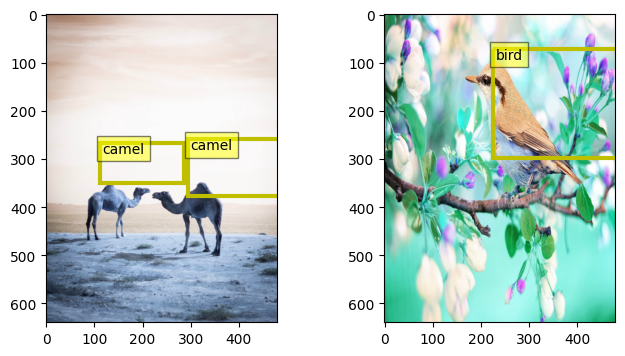

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
req_layers = list(model.children())[:8]
backbone = torch.nn.Sequential(*req_layers)
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True
# run the image through the backbone
out = backbone(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h, out_w

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


(2048, 20, 15)

In [ ]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(24, 42)

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

In [ ]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

In [ ]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])


In [ ]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_boxes(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

In [ ]:
#Get Positive and Negative Anchors

pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)


In [ ]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

tensor([111.0000, 267.5000, 176.0000,  83.0000])
tensor([294.0000, 259.5000, 193.0000, 118.5000])
tensor([225.3333,  72.0000, 322.0000, 226.5000])
tensor([-1., -1.,  0.,  0.])
tensor([105., 252., 168.,  96.])
tensor([315., 276., 168.,  96.])
tensor([210.,  84., 378., 144.])
tensor([210., 108., 378., 144.])
tensor([210., 132., 378., 144.])
tensor([189., 324., 252.,  96.])
tensor([  0.,   0., 147., 108.])
tensor([441., 228., 168.,  96.])
tensor([357., 300.,  84.,  48.])
tensor([ 0., 60., 63., 48.])


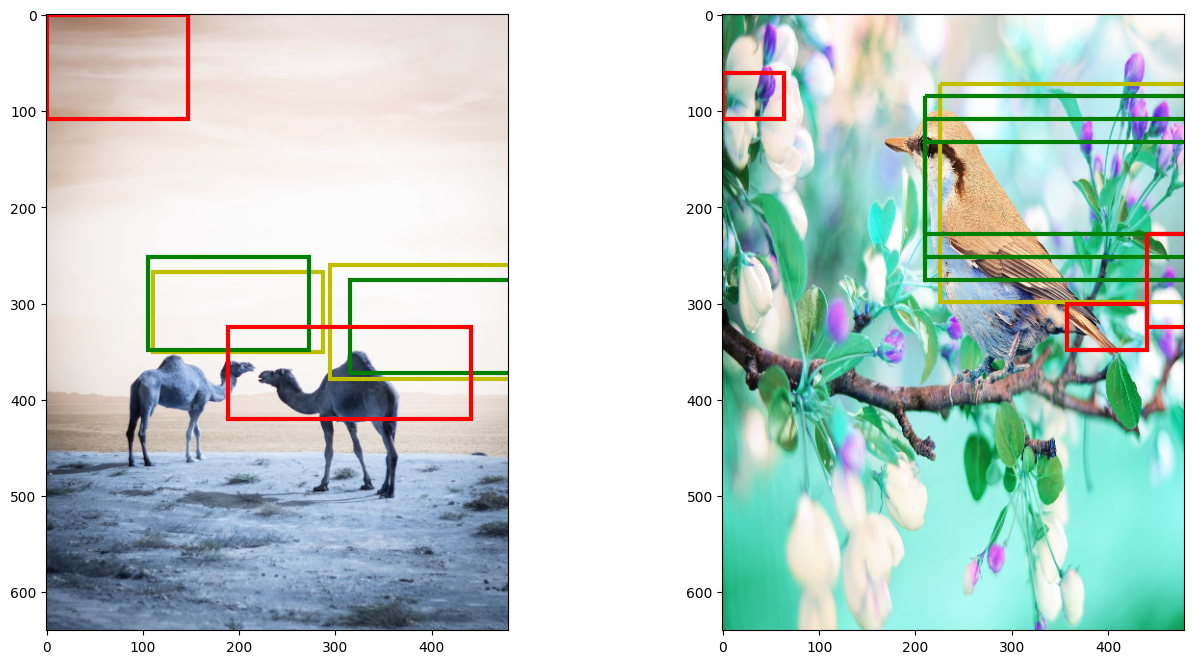

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

In [ ]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [ ]:
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

In [ ]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm.tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [ ]:
learning_rate = 1e-3
n_epochs = 10

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

In [ ]:
plt.plot(loss_list)

In [ ]:
torch.save(detector.state_dict(), "model.pt")

In [ ]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)


In [ ]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)